In [1]:
!pip install yfinance

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 11.6 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 3.1 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=291653 sha256=9a6d5792b9bd4a8e8d121087493bbc0b10741e10717509fe1a1da9d81bfae79f
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee


2024-03-28 03:52:59.625830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-28 03:52:59.625927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-28 03:52:59.793892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Download stock data
symbol = 'VZ'
start_date = '2019-01-01'
end_date = '2024-01-01'
stock_data = yf.download(symbol, start=start_date, end=end_date)
specific_df = pd.DataFrame(stock_data).reset_index()

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Preprocess stock data
specific_df['Date'] = pd.to_datetime(specific_df['Date'])
specific_df['Year'] = specific_df['Date'].dt.year
specific_df['Month'] = specific_df['Date'].dt.month
specific_df['Day'] = specific_df['Date'].dt.day

In [4]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(specific_df[['Close']])

In [5]:
# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

In [6]:
# Generate sequences and labels for LSTM
def generate_sequences_and_labels(data, n_past):
    sequences, labels = [], []
    for i in range(len(data) - n_past):
        sequences.append(data[i:i + n_past])
        labels.append(data[i + n_past, 0])
    return np.array(sequences), np.array(labels)

In [7]:
n_past = 2
x_train, y_train = generate_sequences_and_labels(train_data, n_past)
x_test, y_test = generate_sequences_and_labels(test_data, n_past)
x_train_lstm = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test_lstm = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [8]:
def objective_function(params, X_train, Y_train, X_test, Y_test):

    lstm_units, dropout_rate, dense_units = params

    model = Sequential()
    model.add(LSTM(units=int(lstm_units), return_sequences=True, input_shape=(n_past, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=int(lstm_units/2), return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(int(dense_units), activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, Y_train, epochs=100, verbose=1)

    predictions = model.predict(X_test)
    r2 = r2_score(Y_test, predictions)
    #mse = mean_squared_error(Y_test, predictions)
    return -r2  # negative R-squared for minimization

def particle_swarm_optimization(objective_function, no_particle, no_dim, x_range, v_range, iw_range, c, X_train, Y_train, X_test, Y_test, print_step, iter):

    particles = np.random.uniform([r[0] for r in x_range], [r[1] for r in x_range], size=(no_particle, no_dim))
    velocities = np.random.uniform([r[0] for r in v_range], [r[1] for r in v_range], size=(no_particle, no_dim))
    pbest = np.full(no_particle, np.inf)
    pbestpos = np.zeros((no_particle, no_dim))
    gbest = np.inf
    gbestpos = np.zeros((no_dim,))

    for i in range(iter):

        for j, particle in enumerate(particles):

            fitness = objective_function(particle, X_train, Y_train, X_test, Y_test)

            if fitness < pbest[j]:
                pbest[j] = fitness
                pbestpos[j] = particle.copy()
            if fitness < gbest:
                gbest = fitness
                gbestpos = particle.copy()

        for j, particle in enumerate(particles):
            iw = np.random.uniform(iw_range[0], iw_range[1], 1)[0]
            velocities[j] = (
                iw * velocities[j]
                + (c[0] * np.random.uniform(0.0, 1.0, (no_dim,)) * (pbestpos[j] - particle))
                + (c[1] * np.random.uniform(0.0, 1.0, (no_dim,)) * (gbestpos - particle))
            )
            particles[j] += velocities[j]

    return gbestpos

In [9]:
# Run PSO optimization
no_particle = 10
no_dim = 3
x_range = [(50, 200), (0.1, 0.5), (8, 32)]
v_range = [(1, 10), (0.01, 0.1), (1, 10)]
iw_range = (0.1, 0.5)
c = (1.4962, 1.4962)  # cognitive and social parameters
# Run PSO optimization
best_params = particle_swarm_optimization(objective_function, no_particle, no_dim, x_range, v_range, iw_range, c, x_train, y_train, x_test, y_test, 10, 2)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4323
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0374
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0191
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0165
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063
Epoc

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3524
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4534
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0383
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4757
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4130
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3440
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0201
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0154
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4889
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3144
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0202
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoc

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3615
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017  
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 16/100
3

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3530
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0167
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4271
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4033
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0206
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3582
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3384
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4051
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4171
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0039
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.4328
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3642
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3862
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023
Epoch 16/100
32/

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.3530
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 10/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 11/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016   
Epoch 12/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014   
Epoch 13/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015   
Epoch 14/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014  
Epoch 15/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch

In [10]:
# Define the ranges for LSTM parameters
lstm_units, dropout_rate, dense_units = best_params

In [11]:
# Define the create the main lstm model for final prediction

def lstm_Model(lstm_units, dropout_rate, dense_units, n_past):

  lstm_model = Sequential()
  lstm_model.add(LSTM(units=int(lstm_units), return_sequences=True, input_shape=(n_past, 1)))
  lstm_model.add(Dropout(dropout_rate))
  lstm_model.add(LSTM(units=int(lstm_units/2), return_sequences=False))
  lstm_model.add(Dropout(dropout_rate))
  lstm_model.add(Dense(int(dense_units), activation='relu'))
  lstm_model.add(Dense(1))
  lstm_model.compile(optimizer='adam', loss='mean_squared_error')

  return lstm_model

# Train the LSTM model
lstm_model = lstm_Model(lstm_units, dropout_rate, dense_units, n_past)
history = lstm_model.fit(x_train_lstm, y_train, epochs=200, validation_data=(x_test_lstm, y_test), verbose=1)


Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.4100 - val_loss: 0.0795
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - val_loss: 0.0549
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0073 - val_loss: 0.0382
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - val_loss: 0.0291
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0185
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0103
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0057
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - val_l

In [12]:
# Plotting the learning curve


In [13]:
predictions = lstm_model.predict(x_test)
# Inverse transform the predicted and actual prices
predicted_prices = scaler.inverse_transform(predictions)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [14]:
# Calculate evaluation metrics
r2 = r2_score(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

# Print evaluation metrics
print("R-squared:", r2)
print("MAE:", mae)
print("MSE:", mse)
print("MAPE:", mape)


R-squared: 0.7475732884619145
MAE: 1.0810009002685548
MSE: 1.918495006645826
MAPE: 3.14275218902152


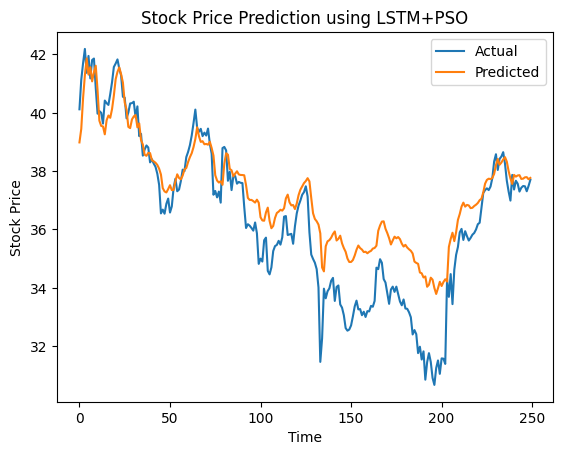

In [15]:
# Plot actual vs predicted prices
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.title('Stock Price Prediction using LSTM+PSO')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()